# EDA



## Exploring the Data


In [2]:
import polars as pl
import polars.selectors as cs
import sklearn 
import catboost

import warnings
warnings.filterwarnings('ignore')

In [3]:
# King County House Sales dataset from OpenML (includes Seattle)
# this is an ARFF file, which is a text file with a specific format
url = 'https://www.openml.org/data/download/22044765/dataset'
cols = ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
        'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
        'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'date_year', 'date_month', 'date_day']

raw = pl.read_csv(url, new_columns=cols, skip_rows=31, has_header=False)
raw

id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_year,date_month,date_day
i64,f64,i64,f64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64
7129300520,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639,2014,12,9
5631500400,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
2487200875,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
1954400510,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
263000018,360000.0,3,2.5,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,21
6600060120,400000.0,4,2.5,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,2,23
1523300141,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,6,23


In [ ]:
raw.describe()

In [ ]:
raw.corr()

In [ ]:
(raw
 .to_pandas(use_pyarrow_extension_array=True)
 .corr()
 .style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)

In [ ]:
(raw
 .plot.scatter('sqft_living', 'price', alpha=0.1)
)

In [ ]:
(raw
 .group_by('date_month', 'zipcode')
 .agg(pl.col('price').mean())
 .plot.line('date_month', 'price', by='zipcode')
 )

In [ ]:
(raw
 .group_by('date_month', 'zipcode')
 .agg(pl.col('price').mean())
 .sort('date_month')
 .plot.line('date_month', 'price', by='zipcode', alpha=0.5)
 )

In [ ]:
# lat/long scatter plot
(raw
 .sort('price')
 .plot.scatter(x='long', y='lat', alpha=0.5, c='price', s=1)
)

In [ ]:
# lat/long scatter plot
(raw
 .filter(pl.col('price') > 1_000_000)
 .sort('price')
 .plot.scatter(x='long', y='lat', alpha=0.5, c='price', s=1)
)


## Data Preprocessing


In [4]:
def tweak_housing(df):
    return (df
            .with_columns(zipcode=pl.col('zipcode').cast(pl.String).cast(pl.Categorical),
                          date=pl.date(pl.col('date_year'), pl.col('date_month'), pl.col('date_day')),
                          yr_renovated=pl.col('yr_renovated').replace(0, None),
                          )
            .select(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                     'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                     'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 
                     'sqft_lot15', 'date',  #'date_year', 'date_month', 'date_day', 
                     ])
    )

tweak_housing(raw)
    

id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date
i64,f64,i64,f64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,cat,f64,f64,i64,i64,date
7129300520,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,null,"""98178""",47.5112,-122.257,1340,5650,2014-10-13
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,"""98125""",47.721,-122.319,1690,7639,2014-12-09
5631500400,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,null,"""98028""",47.7379,-122.233,2720,8062,2015-02-25
2487200875,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,1050,910,1965,null,"""98136""",47.5208,-122.393,1360,5000,2014-12-09
1954400510,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,null,"""98074""",47.6168,-122.045,1800,7503,2015-02-18
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
263000018,360000.0,3,2.5,1530,1131,3.0,0,0,3,8,1530,0,2009,null,"""98103""",47.6993,-122.346,1530,1509,2014-05-21
6600060120,400000.0,4,2.5,2310,5813,2.0,0,0,3,8,2310,0,2014,null,"""98146""",47.5107,-122.362,1830,7200,2015-02-23
1523300141,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,null,"""98144""",47.5944,-122.299,1020,2007,2014-06-23



## Sklearn Pipelines


In [5]:
# The difference between sklearn pipelines and transformers is 
# that a pipeline is a sequence of steps. A transformer transforms
# the data, and a pipeline is a sequence of transformers.
# A ColumnTransformer applies multiple transformers to different
# columns of the input data.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
# use pandas output for sklearn
from sklearn import set_config
set_config(transform_output='polars')

In [6]:
print(tweak_housing(raw).select(cs.numeric()).columns)

['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [ ]:
numeric_features = ['bedrooms', 'bathrooms', 'sqft_living']
std = StandardScaler()
std.fit_transform(tweak_housing(raw).select(numeric_features))

In [ ]:
numeric_features = ['bedrooms', 'bathrooms', 'sqft_living']

num_pipeline = Pipeline([
     ('std', StandardScaler())])

num_pipeline.fit_transform(
    tweak_housing(raw)
    .select(numeric_features)
)

In [ ]:
# add another step
numeric_features = ['bedrooms', 'bathrooms', 'sqft_living']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std', StandardScaler())])

num_pipeline.fit_transform(
    tweak_housing(raw)
    .select(numeric_features)
)

In [ ]:
cat_features = ['zipcode']

ohe = OneHotEncoder(handle_unknown='ignore')
#                    sparse_output=False)

ohe.fit_transform(
    tweak_housing(raw)
    .select(cat_features)
)

In [ ]:
cat_features = ['zipcode']

ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse_output=False)

ohe.fit_transform(
    tweak_housing(raw)
    .select(cat_features)
)

In [ ]:
cat_features = ['zipcode']

ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse_output=False, max_categories=10)

ohe.fit_transform(
    tweak_housing(raw)
    .select(cat_features)
)

In [ ]:
cat_features = ['zipcode']

cat_pipeline = Pipeline(steps=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

cat_pipeline.set_params(cat__max_categories=10)
cat_pipeline.fit_transform(
    tweak_housing(raw)
    .select(cat_features)
)

In [ ]:
# transformer from a function
tweak_transformer = FunctionTransformer(tweak_housing)

tweak_transformer.fit_transform(raw)

In [ ]:
categorical_features = ['zipcode']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

ct = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False), categorical_features)])

ct.fit_transform(
    tweak_housing(raw)
    .select([*numeric_features, *cat_features])
)

In [ ]:
# Custom transformer 
class ZipAvgPriceAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        # assume X is a polars dataframe
        self.zip_avg_price = (X
                              .group_by('zipcode')
                              .agg(zip_mean=pl.col('price').mean())
        )
        return self
    
    def transform(self, X, y=None):
        return X.join(self.zip_avg_price, on='zipcode')

zip_adder = ZipAvgPriceAdder()
zip_adder.fit_transform(raw.select(['zipcode', 'price']))

In [7]:
# make the pipeline
numeric_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
                    'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 
                    'lat', 'long', 'sqft_living15', 'sqft_lot15', 'zip_mean']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['zipcode']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False), categorical_features)])

tweak_transformer = FunctionTransformer(tweak_housing)

class ZipAvgPriceAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        # assume X is a polars dataframe
        self.zip_avg_price = (X
                              .group_by('zipcode')
                              .agg(zip_mean=pl.col('price').mean())
        )
        return self
    
    def transform(self, X, y=None):
        return X.join(self.zip_avg_price, on='zipcode')

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                      ])

X = raw #.drop('price')
y = raw.select('price') # Note sklearn wants a Polars dataframe for y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit_transform(raw, raw.select('price'))

num__bedrooms,num__bathrooms,num__sqft_living,num__sqft_lot,num__floors,num__waterfront,num__view,num__condition,num__grade,num__sqft_above,num__sqft_basement,num__yr_built,num__yr_renovated,num__lat,num__long,num__sqft_living15,num__sqft_lot15,num__zip_mean,cat__zipcode_98001,cat__zipcode_98002,cat__zipcode_98003,cat__zipcode_98004,cat__zipcode_98005,cat__zipcode_98006,cat__zipcode_98007,cat__zipcode_98008,cat__zipcode_98010,cat__zipcode_98011,cat__zipcode_98014,cat__zipcode_98019,cat__zipcode_98022,cat__zipcode_98023,cat__zipcode_98024,cat__zipcode_98027,cat__zipcode_98028,cat__zipcode_98029,cat__zipcode_98030,…,cat__zipcode_98059,cat__zipcode_98065,cat__zipcode_98070,cat__zipcode_98072,cat__zipcode_98074,cat__zipcode_98075,cat__zipcode_98077,cat__zipcode_98092,cat__zipcode_98102,cat__zipcode_98103,cat__zipcode_98105,cat__zipcode_98106,cat__zipcode_98107,cat__zipcode_98108,cat__zipcode_98109,cat__zipcode_98112,cat__zipcode_98115,cat__zipcode_98116,cat__zipcode_98117,cat__zipcode_98118,cat__zipcode_98119,cat__zipcode_98122,cat__zipcode_98125,cat__zipcode_98126,cat__zipcode_98133,cat__zipcode_98136,cat__zipcode_98144,cat__zipcode_98146,cat__zipcode_98148,cat__zipcode_98155,cat__zipcode_98166,cat__zipcode_98168,cat__zipcode_98177,cat__zipcode_98178,cat__zipcode_98188,cat__zipcode_98198,cat__zipcode_98199
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.398737,-1.447464,-0.979835,-0.228321,-0.915427,-0.087173,-0.305759,-0.629187,-0.558836,-0.734708,-0.658681,-0.544898,0.053508,-0.352572,-0.306079,-0.943355,-0.260715,-0.979321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
-0.398737,0.175607,0.533634,-0.189885,0.936506,-0.087173,-0.305759,-0.629187,-0.558836,0.460841,0.245141,-0.681079,-2.67545,1.161568,-0.746341,-0.432686,-0.187868,-0.301434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.473959,-1.447464,-1.426254,-0.123298,-0.915427,-0.087173,-0.305759,-0.629187,-1.409587,-1.229834,-0.658681,-1.293892,0.053508,1.283537,-0.135655,1.07014,-0.172375,-0.331204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.676485,1.149449,-0.13055,-0.244014,-0.915427,-0.087173,-0.305759,2.444294,-0.558836,-0.891699,1.397515,-0.204446,0.053508,-0.283288,-1.271816,-0.914174,-0.284522,0.049507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.398737,-0.149007,-0.435422,-0.169653,-0.915427,-0.087173,-0.305759,-0.629187,0.291916,-0.130895,-0.658681,0.544548,0.053508,0.40955,1.199335,-0.27219,-0.192849,0.621019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.398737,0.500221,-0.598746,-0.337424,2.788439,-0.087173,-0.305759,-0.629187,0.291916,-0.312039,-0.658681,1.293542,0.053508,1.004958,-0.938069,-0.666135,-0.412381,0.191323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
pipe

In [ ]:
# Note sklearn wants a Polars dataframe for y
X = raw #.drop('price')
y = raw.select('price') 
#y = raw['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Challenge

Make a plot to explore the relationship between the number of bedrooms and the price of the house.


## Solution

In [ ]:
(tweak_housing(raw)
  .plot.scatter(x='bedrooms', y='price', alpha=.01, yformatter='%.0f')
)

In [ ]:
(tweak_housing(raw)
  .plot.scatter(x='bedrooms', y='price', alpha=.1, size=1, yformatter='%.0f')
  .opts(jitter=.8)
)

# Model Creation



## Dummy Model


In [ ]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='mean')
y = raw.select('price')
X_train, X_test, y_train, y_test = train_test_split(raw, y, test_size=0.2, random_state=42)
dummy_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                      ('dummy', dummy),
                      ])

dummy_pipe.fit(X_train, y_train)
dummy_pipe.score(X_test, y_test)

In [ ]:
dummy_pipe

In [ ]:
dummy_pipe.predict(X_test)


## Linear Regression


In [15]:
from sklearn.linear_model import LinearRegression


lr =  LinearRegression()
y = raw.select('price')
X_train, X_test, y_train, y_test = train_test_split(raw, y, test_size=0.2, random_state=42)
lr_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                        ('lr', lr),
                      ])

lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_test, y_test)

0.8069953800756082

In [ ]:
lr_pipe.predict(X_test)


## Decision Trees


In [23]:
from sklearn.tree import DecisionTreeRegressor


dt = DecisionTreeRegressor()
y = raw.select('price')
X_train, X_test, y_train, y_test = train_test_split(raw, y, test_size=0.2, random_state=42)
dt_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                      ('dt', dt),
                      ])

dt_pipe.fit(X_train, y_train)
dt_pipe.score(X_test, y_test)

0.7361694188624901

In [ ]:
dt_pipe.set_params(dt__max_depth=1)
dt_pipe.fit(X_train, y_train)
dt_pipe.score(X_test, y_test)

In [ ]:
dt_pipe.set_params(dt__max_depth=9)
dt_pipe.fit(X_train, y_train)
dt_pipe.score(X_test, y_test)


## CatBoost


In [8]:
from catboost import CatBoostRegressor


cat = CatBoostRegressor()
# has issues with Polars input going to use a pandas_transformer
def to_pandas(df):
    return df.to_pandas()
pandas_transformer = FunctionTransformer(to_pandas)

y = raw.select('price')

X_train, X_test, y_train, y_test = train_test_split(raw, y, test_size=0.2, random_state=42)
cat_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                      ('to_pandas', pandas_transformer),
                      ('cat', cat), 
                      ])

cat_pipe.fit(X_train, y_train.to_numpy()[:,0])
cat_pipe.score(X_test, y_test.to_numpy()[:,0])

Learning rate set to 0.064232
0:	learn: 346982.2594620	total: 58.6ms	remaining: 58.6s
1:	learn: 332378.5598059	total: 68.5ms	remaining: 34.2s
2:	learn: 319502.6617458	total: 80ms	remaining: 26.6s
3:	learn: 307490.7902475	total: 90.4ms	remaining: 22.5s
4:	learn: 294940.3225791	total: 100ms	remaining: 19.9s
5:	learn: 283907.9796375	total: 109ms	remaining: 18.1s
6:	learn: 273592.5548762	total: 113ms	remaining: 16.1s
7:	learn: 263472.9134855	total: 117ms	remaining: 14.5s
8:	learn: 254884.3331936	total: 120ms	remaining: 13.2s
9:	learn: 246261.9209853	total: 124ms	remaining: 12.2s
10:	learn: 238183.5765242	total: 127ms	remaining: 11.4s
11:	learn: 230600.1564374	total: 132ms	remaining: 10.8s
12:	learn: 223779.4367347	total: 135ms	remaining: 10.3s
13:	learn: 217021.8170437	total: 138ms	remaining: 9.75s
14:	learn: 210875.7711670	total: 142ms	remaining: 9.3s
15:	learn: 205122.1910805	total: 145ms	remaining: 8.94s
16:	learn: 199643.2642325	total: 149ms	remaining: 8.61s
17:	learn: 194468.6623792	t

0.9046473600451286


## Challenge

Create a pipeline for a Random Forest model and train it on the data. (see `ensemble.RandomForestRegressor` in scikit-learn). What is the score?



## Solution

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
y = raw.select('price')
X_train, X_test, y_train, y_test = train_test_split(raw, y, test_size=0.2, random_state=42)
rf_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                      ('rf', rf),
                      ])

rf_pipe.fit(X_train, y_train)
rf_pipe.score(X_test, y_test)

0.8730702090576012

# Evaluation



## R2


The Coefficient of Determination, R2, is a measure of how well the model fits the data. It is a value between 0 and 1. It tells us how much of the variance in the target variable is predictable from the features.

A value of 0 means that the model explains none of the variability. A value of 1 means that the model explains all the variability.

Note that it doesn't indicate whether a model is overfitting or underfitting the data.

In [10]:
cat_pipe.score(X_test, y_test.to_numpy()[:,0])

0.9046473600451286


## Mean Squared/Absolute Error


In [11]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, cat_pipe.predict(X_test))

14415098613.389244

In [12]:
# rmse
mean_squared_error(y_test, cat_pipe.predict(X_test), squared=False)

120062.89440701171

In [13]:
# absolute error
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, cat_pipe.predict(X_test))

64449.15608948771

In [17]:
# compare to lr model
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, lr_pipe.predict(X_test))

98918.93077723803


## Residuals Plot


Text(0.5, 1.0, 'Residual plot')

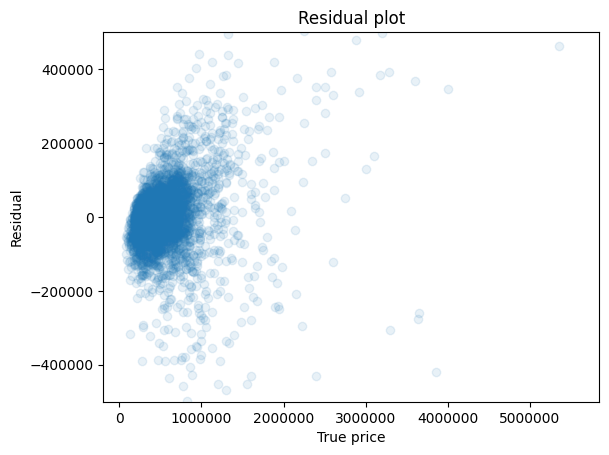

In [18]:
# make a residual plot
import matplotlib.pyplot as plt

ax = plt.scatter(y_test, 
    y_test.to_series().to_numpy() - cat_pipe.predict(X_test), alpha=0.1)
# make labels not be scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
# set y limits to -500,000 to 500,000
plt.ylim(-500_000, 500_000)
plt.xlabel('True price')
plt.ylabel('Residual')
plt.title('Residual plot')

In [21]:
# plot with Polars
(y_test
 .with_columns(residual=y_test.to_series().to_numpy() - cat_pipe.predict(X_test))
 .plot.scatter('price', 'residual', alpha=0.1, yformatter='$%.0f')
 )

:Scatter   [price]   (residual)

Text(0.5, 1.0, 'Residual plot')

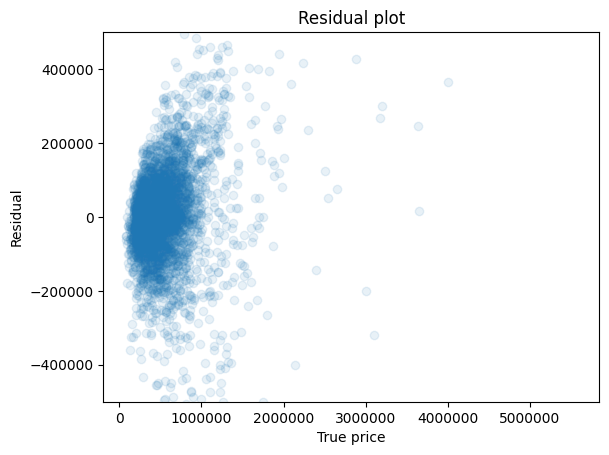

In [24]:
# make a residual plot for decision tree

ax = plt.scatter(y_test, 
    y_test.to_series().to_numpy() - dt_pipe.predict(X_test), alpha=0.1)
# make labels not be scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.ylim(-500_000, 500_000)
plt.xlabel('True price')
plt.ylabel('Residual')
plt.title('Residual plot')

Text(0.5, 1.0, 'Residual plot')

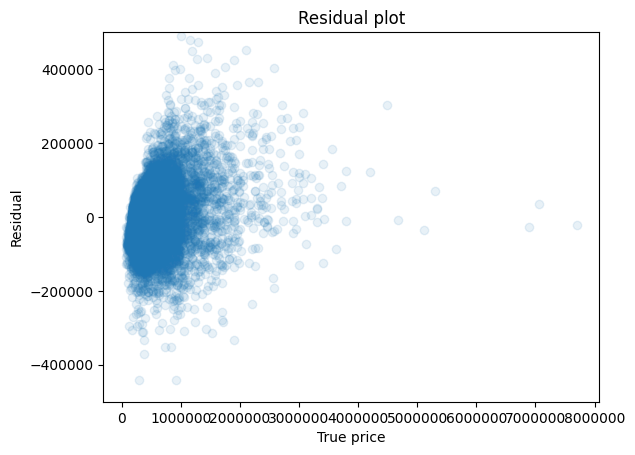

In [25]:
# contrast this with the training data

ax = plt.scatter(y_train, 
     y_train.to_series().to_numpy() - cat_pipe.predict(X_train), alpha=0.1)
# make labels not be scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.ylim(-500_000, 500_000)
plt.xlabel('True price')
plt.ylabel('Residual')
plt.title('Residual plot')

## Challenge

What is the mean squared error of the Random Forest model? What is the R2 score? What do these values tell us about the model?



## Solution

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, cat_pipe.predict(X_test))

14415098613.389244

In [27]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, rf_pipe.predict(X_test))

19188828482.12197

In [29]:
from sklearn.metrics import r2_score
r2_score(y_test, cat_pipe.predict(X_test))

0.9046473600451286

In [30]:
from sklearn.metrics import r2_score
r2_score(y_test, rf_pipe.predict(X_test))

0.8730702090576012

# Model Tuning



## Hyperparameters

Hyperparameters are the levers we can pull to adjust the behavior of a model. They are set before the model is trained and remain constant during training.


## Tuning Linear Regression


In [ ]:
lr_pipe

In [ ]:
lr_pipe.named_steps['lr']

In [ ]:
help(lr_pipe.named_steps['lr'])

In [ ]:
from sklearn.linear_model import Ridge
Ridge?

In [ ]:
rr =  Ridge()
y = raw.select('price')
X_train, X_test, y_train, y_test = train_test_split(raw, y, test_size=0.2, random_state=42)
rr_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                        ('rr', rr),
                      ])

rr_pipe.fit(X_train, y_train)
rr_pipe.score(X_test, y_test)

In [ ]:
lr_pipe.score(X_test, y_test)

In [ ]:
from sklearn.model_selection import validation_curve

param_range = [0, .01, .05, .1, .5, 1, 2]
scores = []
for val in param_range:
    rr_pipe.set_params(rr__alpha=val)
    rr_pipe.fit(X_train, y_train)
    scores.append(rr_pipe.score(X_test, y_test))

In [ ]:
# Our be score is at 0 (which is normal Linear Regression)
alpha = pl.DataFrame({'val': param_range,
              'scores': scores})
alpha.plot(x='val', y='scores')


## Tuning Decision Trees


In [ ]:
dt_pipe.named_steps['dt']

In [ ]:
help(dt_pipe.named_steps['dt'])

In [ ]:
# plot a validation curve tracking mse as the max_depth of the decision tree increases
from sklearn.model_selection import validation_curve

param_range = range(1, 20)
train_scores, test_scores = validation_curve(
    dt_pipe, X_train, y_train, param_name="dt__max_depth", param_range=param_range,
    scoring="neg_mean_squared_error", n_jobs=1)

In [ ]:
# make a validation curve from train_scores and test_scores
import matplotlib.pyplot as plt
import numpy as np

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Decision Tree")
plt.xlabel("max_depth")
plt.ylabel("Score")
#plt.ylim(-1, 0)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,   
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
plt.legend(loc="best")




In [ ]:
# train dt_pipe with max_depth=8
dt8_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                        ('zip_avg_price', ZipAvgPriceAdder()),
                        ('to_pandas', pandas_transformer),
                        ('preprocessor', preprocessor),
                        ('dt', DecisionTreeRegressor(max_depth=8)),
                        ])

dt8_pipe.fit(X_train, y_train)
dt8_pipe.score(X_test, y_test)

In [ ]:
mean_squared_error(y_test, dt8_pipe.predict(X_test), squared=False) 

In [ ]:
dt_pipe.score(X_test, y_test)

In [ ]:
mean_squared_error(y_test, dt_pipe.predict(X_test), squared=False) 


## Tuning CatBoost

* Boosting - `iterations` (`num_trees`, `n_estimators`), `learning_rate` (`eta`), `early_stopping_rounds`

* Tree based - `depth` (`max_depth`), `grow_policy`, `min_child_samples` (`min_data_in_leaf`), `max_leaves` (`num_leaves`)

* Sampling - `subsample`, `sampling_frequency`, `rsm` (`colsample_bylevel`), `random_strength`, `bagging_temperature`

* Regularization - `l2_leaf_reg` (`reg_lambda`), `model_shrink_rate`

* Constraints - `monotone_constraints`, `feature_weights`

In [ ]:
catboost.CatBoostRegressor?

In [ ]:
cr2 = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.1,
                                 early_stopping_rounds=10)
X_train, X_test, y_train, y_test = train_test_split(raw.drop('price'), y, 
                                                    test_size=0.2, random_state=42)

cr2.fit(X_train.to_pandas(), y_train.to_numpy(), cat_features=['zipcode'], verbose=100,
        early_stopping_rounds=10, eval_set=(X_test.to_pandas(), y_test.to_numpy()))

In [ ]:
# plot a validation curve tracking mse as the max_depth of the decision tree increases
from sklearn.model_selection import validation_curve

param_range = range(1, 10)
train_scores, test_scores = validation_curve(
    cr2, X_train.to_pandas(), y_train.to_numpy(), param_name="max_depth", 
    param_range=param_range,
    scoring="neg_mean_squared_error", n_jobs=1,
    fit_params=dict(early_stopping_rounds=10, 
                    eval_set=(X_test.to_pandas(), y_test.to_numpy())))

In [ ]:
# make a validation curve from train_scores and test_scores
import matplotlib.pyplot as plt
import numpy as np

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with CatBoost")
plt.xlabel("max_depth")
plt.ylabel("Score")
#plt.ylim(-1, 0)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,   
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
plt.legend(loc="best")




In [ ]:
# set max_depth to 4
cr2_4 = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.1,
                                max_depth=4)

X_train, X_test, y_train, y_test = train_test_split(raw.drop('price'), y, 
                                                    test_size=0.2, random_state=42)

cr2_4.fit(X_train.to_pandas(), y_train.to_numpy(), cat_features=['zipcode'], verbose=100,
        early_stopping_rounds=10, eval_set=(X_test.to_pandas(), y_test.to_numpy()))
cr2_4.score(X_test.to_pandas(), y_test.to_numpy())


## Grid Search


In [ ]:
from sklearn.tree import DecisionTreeRegressor


dt = DecisionTreeRegressor()
y = raw.select('price')
X_train, X_test, y_train, y_test = train_test_split(raw, y, test_size=0.2, random_state=42)
dt_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                      ('dt', dt),
                      ])

dt_pipe.fit(X_train, y_train)
dt_pipe.score(X_test, y_test)

In [ ]:
dt_pipe

In [ ]:
# use grid search on decision tree
from sklearn.model_selection import GridSearchCV

param_grid = {
    'dt__max_depth': [3, 6, 9],
    'dt__min_samples_split': [10, 20, 100],
    'dt__min_samples_leaf': [10, 20, 100],
}

grid_search = GridSearchCV(dt_pipe, param_grid, cv=5)#, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
# make a tree from the params
dt = DecisionTreeRegressor()#max_depth=9, min_samples_leaf=20, min_samples_split=10)
dt_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('to_pandas', pandas_transformer),
                      ('preprocessor', preprocessor),
                        ('dt', dt),
                      ])
dt_pipe.set_params(**grid_search.best_params_)
dt_pipe.fit(X_train, y_train)
dt_pipe.score(X_test, y_test)

In [ ]:
# compare to default
dt = DecisionTreeRegressor(random_state=42)
dt_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('to_pandas', pandas_transformer),
                      ('preprocessor', preprocessor),
                        ('dt', dt),
                      ])

dt_pipe.fit(X_train, y_train)
dt_pipe.score(X_test, y_test)


## Challenge

Do a grid search to find the best depth for the random forest model. What is the best depth? What is the score of the model with the best depth?


## Solution

# Model Deployment



## End to end notebook


In [ ]:
import polars as pl
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
# use pandas output for sklearn
from sklearn import set_config
set_config(transform_output='polars')

def tweak_housing(df):
    return (df
            .with_columns(zipcode=pl.col('zipcode').cast(pl.String).cast(pl.Categorical),
                          date=pl.date(pl.col('date_year'), pl.col('date_month'), pl.col('date_day')),
                          yr_renovated=pl.col('yr_renovated').replace(0, None),
                          )
            .select(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                     'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                     'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 
                     'sqft_lot15', 'date',  #'date_year', 'date_month', 'date_day', 
                     ])
    )

# make the pipeline
numeric_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
                    'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 
                    'lat', 'long', 'sqft_living15', 'sqft_lot15', 'zip_mean']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['zipcode']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False), categorical_features)])

def to_pandas(df):
    return df.to_pandas()
pandas_transformer = FunctionTransformer(to_pandas)

tweak_transformer = FunctionTransformer(tweak_housing)

class ZipAvgPriceAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        # assume X is a polars dataframe
        self.zip_avg_price = (X
                              .group_by('zipcode')
                              .agg(zip_mean=pl.col('price').mean())
        )
        return self
    
    def transform(self, X, y=None):
        with pl.StringCache():
            return X.join(self.zip_avg_price, on='zipcode')


# King County House Sales dataset from OpenML (includes Seattle)
# this is an ARFF file, which is a text file with a specific format
url = 'https://www.openml.org/data/download/22044765/dataset'
cols = ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
        'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
        'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'date_year', 'date_month', 'date_day']

raw = pl.read_csv(url, new_columns=cols, skip_rows=31, has_header=False)

lr =  LinearRegression()
y = raw.select('price')
X_train, X_test, y_train, y_test = train_test_split(raw, y, test_size=0.2, random_state=42)
lr_pipe = Pipeline(steps=[('tweak', tweak_transformer),
                      ('zip_avg_price', ZipAvgPriceAdder()),
                      ('preprocessor', preprocessor),
                      ('lr', lr),
                      ])

lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_test, y_test)
    

## Using MLFlow

Going to show how to persist and load a model, but can also:

- Start a endpoint to serve predictions
- Build a Docker image


In [ ]:
import mlflow

In [ ]:
mlflow.__version__

In [ ]:
model_info = mlflow.sklearn.log_model(lr_pipe, artifact_path='lr_pipe')

In [ ]:
model_info.artifact_path    

In [ ]:
!tree

In [ ]:
model_info.run_id

In [ ]:
model = mlflow.pyfunc.load_model(f'mlruns/0/{model_info.run_id}/artifacts/lr_pipe')

In [ ]:
model.predict(X_test)

## Challenge

Reformat your notebook so that you can load the data and create an optimized random forest model in a single cell. Then, use MLFlow to log the model and its parameters.


## Solution